Script by Lars Kjær

The code is the second part of our work with handling the outliers. The first part is in the notebook "Find_matching_row". This notebook builds upon the data produced by the code in the first note book. It handles the remaining outliers in a methodical way that is grounded in literature and a statistical method. _Source Eric Kleppen : https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/_

The approach follows three steps. First step is to use data visualisation to verify the presents of outliers. The second step is to use a statistical method to calculate the outliers. The third step is to drop or transform the outliers. 

In [98]:
##################### Import libraries ################################

import pandas as pd
import os
import re
from pathlib import Path
import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [99]:
'''
The function takes a dataframe and a column name as input  
and calculates the first and third quartiles along with the IQR. 
Then it identifies outliers using the IQR-based method and 
returns a new DataFrame with out the outliers.

The function have is origin in a code written by Eric Kleppen but is implemented by the me to work on our data.  
'''

def remove_outliers_IQR(data_frame, column_name):

    # Extract the specified column as a Series
    data_series = data_frame[column_name]

    # Calculate the first quartile (Q1) and the third quartile (Q3)
    q1 = data_series.quantile(0.25)
    q3 = data_series.quantile(0.75)

    # Calculate the Interquartile Range (IQR)
    IQR = q3 - q1

    # Determine the lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    # Select data points that are not outliers based on the bounds
    not_outliers_df = data_frame[(data_frame[column_name] >= lower_bound) & (data_frame[column_name] <= upper_bound)]

    return not_outliers_df

In [100]:
input_fp = Path.cwd() / 'unique_data' # path of files to be found

output_fp = Path.cwd() / 'inlier_data' # output path of files generated
# Use the Path object to actually create the subfolder
Path.mkdir(output_fp, exist_ok=True)


outliers_dropped = []
muni_codes = []

    
for filename in tqdm.tqdm(sorted(os.listdir(input_fp))): # 
    if filename.startswith('unique_sales_1992_2022_') and filename.endswith('.csv'):
        input_df = pd.read_csv(input_fp/filename, low_memory=False) # read the CSV file into a DataFrame
        column_name = 'square_meters_price'
        output_df = remove_outliers_IQR(input_df, column_name) ## apply function
        # keep track of rows removed
        col_removed = len(input_df) - len(output_df) 
        outliers_dropped.append(col_removed)
        muni_codes.append(output_filename[-7:-4])
        # save file
        # Rename and save the new DataFrame to a CSV file without index numbers
        output_filename = filename.replace('unique_', 'inlier_')
        output_df.to_csv(f'{output_fp}/{output_filename}', index=False)

        
        
outliers_dropped_df = pd.DataFrame({'outliers': outliers_dropped, 'muni_code': muni_codes})
# Save file with information on how many outliers that have been dropped for each minicipality
outliers_dropped_df.to_csv('outliers_dropped_df.csv', index=False, encoding='utf-8')

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.22it/s]


# Detecting and Filtering Outliers

The following is a walkthrough of the code above and it also serves to make visualisation.

In [87]:
# Import a subset of data 
df = pd.read_csv(r'unique_data/unique_sales_1992_2022_101.csv')

df.describe()

C:\Users\lakj\AppData\Local\Temp\ipykernel_14428\1293142333.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'unique_data/unique_sales_1992_2022_101.csv')


,municipality,zip_code,square_meters,square_meters_price,rooms,year_of_construction
count,240028.0,240028.000000,240028.000000,2.400280e+05,240028.000000,240028.000000
mean,101.0,2226.761586,86.509874,3.767274e+04,2.989447,1908.656148
std,0.0,375.171278,41.446203,9.218745e+04,1.381030,229.188820
min,101.0,1001.000000,11.000000,0.000000e+00,1.000000,0.000000
25%,101.0,2100.000000,57.000000,1.135575e+04,2.000000,1905.000000
50%,101.0,2300.000000,74.000000,2.190350e+04,3.000000,1934.000000
75%,101.0,2450.000000,106.000000,3.518500e+04,4.000000,1962.000000
max,101.0,2903.000000,971.000000,4.730769e+06,35.000000,2023.000000


# Use data visualisation to verify the presents of outliers

I use historgram and box plot as visualization methods to find outliers in data.


The histogram illustrates how the data is distributed. Eric Kleppen writes: _Having data that follows a normal distribution is necessary for some of the statistical techniques used to detect outliers. If the data doesn’t follow a normal distribution, the z-score calculation shouldn’t be used to find the outliers._ 

In [88]:
import seaborn as sns

<Axes: xlabel='square_meters_price', ylabel='Count'>

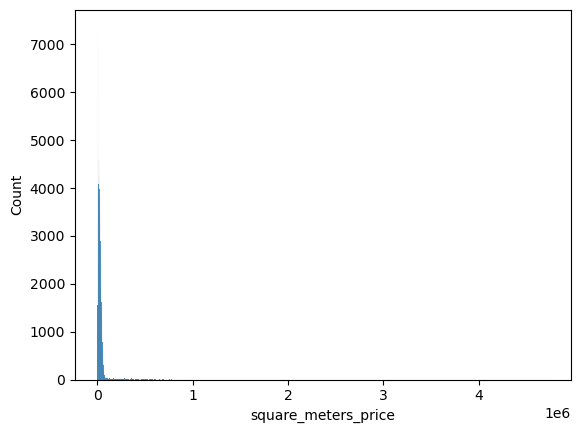

In [89]:
sns.histplot(df, x='square_meters_price')

Notice the data does not follow a normal distribution. Since the data is skewed, instead of using a z-score we can use **interquartile range (IQR)** to determine the outliers. We will explore using IQR after reviewing the other visualization techniques.

# Find outliers in data using a box plot


<Axes: ylabel='square_meters_price'>

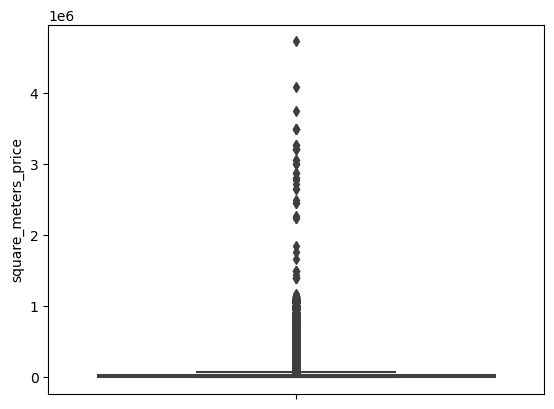

In [90]:
#create a box plot

sns.boxplot(df, y='square_meters_price')

# Find outliers using statistical methods and drop them

Using this method, we essentially drop all the outliers from the data, excluding them from the analysis and modeling. Although this technique is quick and easy, it isn’t always the right solution and can reduce the amount of data if there are a lot of outliers present. 

Copy and paste the find_outliers_IQR function **( IQR = interquartile range )** so we can modify it to return a dataframe with the outliers removed. Rename it drop_outliers_IQR . Inside the function we create a dataframe named not_outliers that replaces the outlier values with a NULL. Then we can use .dropna(), to drop the rows with NULL values. 

In [91]:
# we will calculate the outlier data points using the statistical method called interquartile range (IQR) instead of using Z-score. Using the IQR, the outlier data points are the ones falling below Q1–1.5 IQR or above Q3 + 1.5 IQR. The Q1 is the 25th percentile and Q3 is the 75th percentile of the dataset, and IQR represents the interquartile range calculated by Q3 minus Q1 (Q3–Q1). 

# Using the convenient pandas .quantile() function, 
# we can create a simple Python function that takes in our column from the dataframe and outputs the outliers:

#create a function to find outliers using IQR


def remove_outliers_IQR(data_frame, column_name= 'square_meters_price'):

    # Extract the specified column as a Series
    data_series = data_frame[column_name]

    # Calculate the first quartile (Q1) and the third quartile (Q3)
    q1 = data_series.quantile(0.25)
    q3 = data_series.quantile(0.75)

    # Calculate the Interquartile Range (IQR)
    IQR = q3 - q1

    # Determine the lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    # Select data points that are not outliers based on the bounds
    not_outliers_df = data_frame[(data_frame[column_name] >= lower_bound) & (data_frame[column_name] <= upper_bound)]

    return not_outliers_df

<Axes: xlabel='square_meters_price', ylabel='Count'>

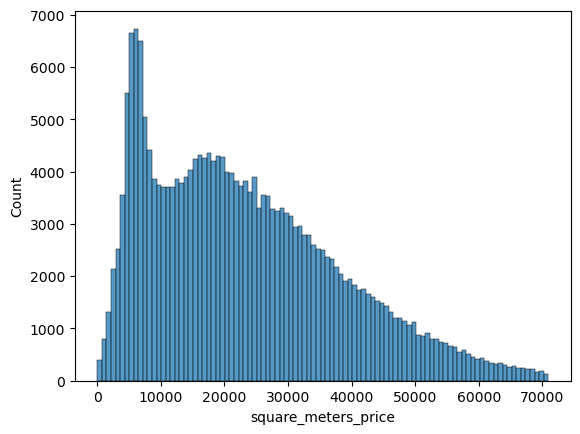

In [92]:
output_df =  remove_outliers_IQR(df)
sns.histplot(output_df, x='square_meters_price')

<Axes: ylabel='square_meters_price'>

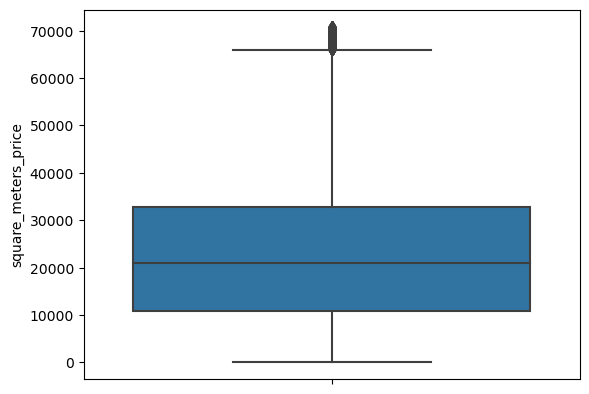

In [93]:
#create a box plot

sns.boxplot(output_df, y='square_meters_price')

In [94]:
# Source : http://pbpython.com/effective-matplotlib.html

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


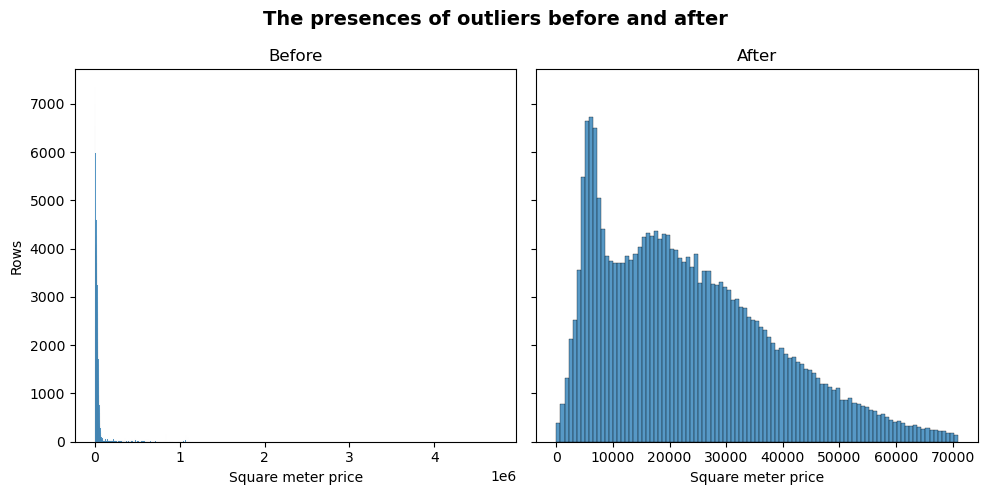

In [95]:
# Get the figure and the axes
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10, 5))

# fig 1
sns.histplot(df, x='square_meters_price', ax=ax0)
ax0.set(title='Before', xlabel='Square meter price', ylabel='Rows')

# fig 2
sns.histplot(output_df, x='square_meters_price', ax=ax1)
ax1.set(title='After', xlabel='Square meter price', ylabel='Rows')

# Title the figure
fig.suptitle('The presences of outliers before and after', fontsize=14, fontweight='bold');

# Hide the legends
ax1.legend().set_visible(False)
ax0.legend().set_visible(False)

# Display the plots
plt.tight_layout()
plt.show()

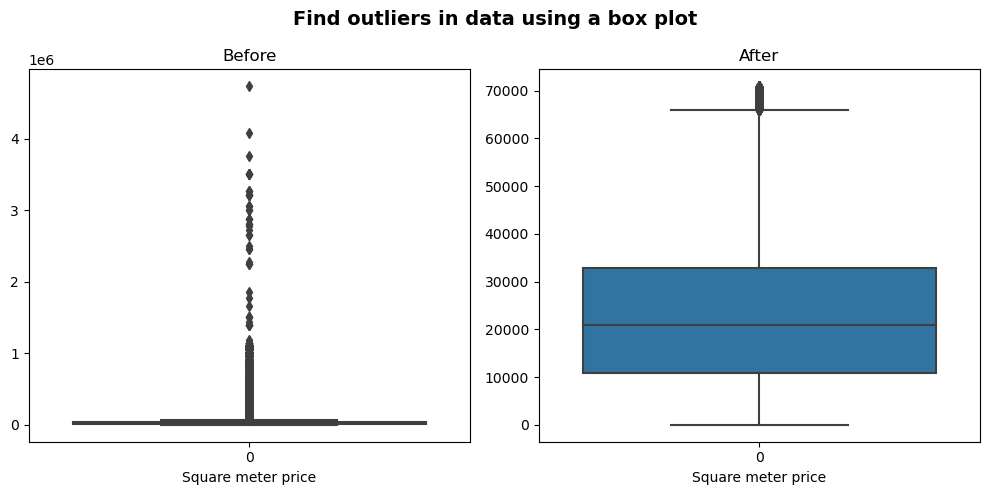

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and subplots with two columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Create the first box plot in the first subplot
data1 = df['square_meters_price']
sns.boxplot(data=data1, ax=axes[0])
axes[0].set_title('Before')
axes[0].set_xlabel('Square meter price')

# Create the second box plot in the second subplot
data2 = output_df['square_meters_price']
sns.boxplot(data=data2, ax=axes[1])
axes[1].set_title('After')
axes[1].set_xlabel('Square meter price')

# Title the figure
fig.suptitle('Find outliers in data using a box plot', fontsize=14, fontweight='bold');

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [97]:
output_df

,municipality,housing_type,address,zip_code,town,purchase_amount,date_of_sale,type_of_sale,square_meters,square_meters_price,rooms,year_of_construction,The percentage difference between the latest bid price and the sale price
0,101,Ejerlejlighed,"Allersgade 2, 4. th",2200,København N,3950000,30-12-2022,Alm. Salg,97,40722,3,1990,-1%
1,101,Ejerlejlighed,"Birketinget 2F, st. 602",2300,København S,1695000,30-12-2022,Alm. Salg,45,37667,1,1970,NaN
2,101,Ejerlejlighed,"Himmerlandsvej 17, st. th",2720,Vanløse,1775000,30-12-2022,Alm. Salg,55,32273,2,1934,-6%
3,101,Ejerlejlighed,"Randersgade 49, 3. th",2100,København Ø,4050000,30-12-2022,Alm. Salg,70,57857,3,1893,-3%
4,101,Villa,Dyssevænget 4B,2700,Brønshøj,1100000,30-12-2022,Fam. Salg,100,11000,5,1964,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
240023,101,Ejerlejlighed,"Kildevældsgade 68, st. th",2100,København Ø,290000,01-01-1992,Auktion,59,4915,2,1903,NaN
240024,101,Ejerlejlighed,"Christianshavns Voldgade 3, 4. tv",1424,København K,620000,01-01-1992,Alm. Salg,75,8267,3,1894,NaN
240025,101,Ejerlejlighed,"Genforeningspladsen 16, st. th",2400,København NV,448000,01-01-1992,Alm. Salg,63,7111,2,1928,NaN
240026,101,Villa,Tryggevældevej 148,2700,Brønshøj,240000,01-01-1992,Auktion,82,2927,3,1934,NaN
